# Multilayer Perception Tutorial

By: Michael Vigdorchik

## In this tutorial, we will cover:

* N-layer MLP with PyTorch's `nn.Module`, `nn.NNLoss` and `optim` modules
* A simpler approach with `scikit learn` tools

In [24]:
# Setup
%matplotlib inline
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Sequence

plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (9,9)

# Some Theory

The following hypothesis class
$$
\mathcal{H} =
\left\{ h: \mathcal{X}\rightarrow\mathcal{Y}
~\vert~
h(\vec{x}) = \varphi(\vec{w}^T\vec{x}+b); \vec{w}\in\set{R}^D,~b\in\set{R}\right\}
$$
where $\varphi(\cdot)$ is some nonlinear function, is composed of functions representing the **perceptron** model.


<img src="perceptron.png" width=400 /> 

# The Dataset we'll be working with: the MNIST hand written digits

In [25]:
import torchvision
from torchvision import datasets, transforms

In [26]:
# Define a transform to normalize the data
# -0.5 to +0.5 are converted to values in range 0 to 1

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=(0.5,), std=(0.5,)),
                              ])

In [27]:
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [28]:
dataiter = iter(trainloader)

images, labels = dataiter.next()

torch.Size([64, 1, 28, 28])
torch.Size([64])


Label = 1




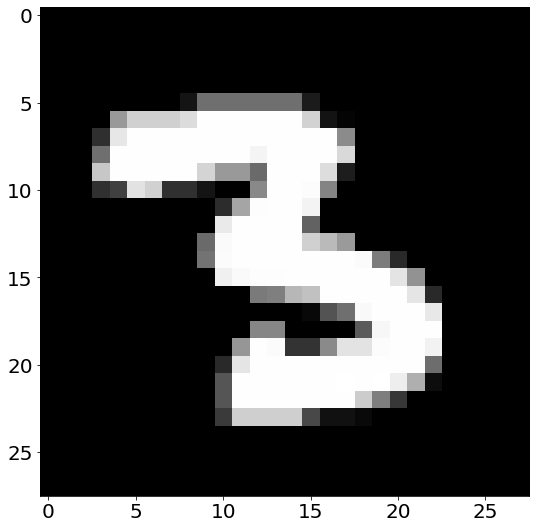

In [30]:
print(images.shape)
print(labels.shape)
plt.imshow(images[18].numpy().squeeze(), cmap='Greys_r');

print(f'\n\nLabel = {labels[17]}\n\n')

In [31]:
trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [32]:
n_features = torch.numel(images[17])
n_classes = 10

In [33]:
n_features  # 28 x 28 (pixels that are inputs to a perceptron)

784

# N-Layer MLP using PyTorch

* Dataset
* Model
* Loss function
* Optimizer

## Dataset

### Load the MNIST dataset "lazily" with batches and a "smart" DataLoader

In [12]:
BATCH_SIZE = 512
TRAIN_SIZE = BATCH_SIZE * 10
TEST_SIZE  = BATCH_SIZE * 2

In [34]:
# Datasets and loaders
train_set    = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           sampler=torch.utils.data.SubsetRandomSampler(range(TRAIN_SIZE)))
             

In [35]:
            
test_set    = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)


test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                          sampler=torch.utils.data.SubsetRandomSampler(range(TEST_SIZE)))

## Multilayer Perceptron (MLP)

### Model

<center><img src="mlp.png" width=1000 /></center>





Composed of $L$ **layers**, each layer $l$ with $n_l$ **perceptron** ("neuron") units.

$$\hat{y} = \varphi(\mat{w}^T\vec{x}+b).$$



Each layer $l$ operates on the output of the previous layer

Given an input sample $\vec{x}^i$, the computed function of an $L$-layer MLP is:
$$
\hat{\vec{y}_L^i}= \varphi \left(
\mat {W}_L \varphi \left( \cdots
\varphi \left( \mat{W}_1 \vec{x}^i + \vec{b}_1 \right)
\cdots \right)
+ \vec{b}_L \right)
$$

# Model Implementation

In [36]:
import torch.nn as nn

### Let's inherit pytorch's base class for all neural network modules, and modify it according to our needs

In [16]:
class MLP(torch.nn.Module):
    
    def __init__(self, D_in, hidden_dims, D_out):
        super().__init__()
        
        all_dims = [D_in, *hidden_dims, D_out]
        non_linearity = torch.nn.ReLU
        layers = []
        
        
        # build the layers
        for in_dim, out_dim in zip(all_dims[:-1], all_dims[1:]):
            layers += [
                nn.Linear(in_dim, out_dim, bias=True),
                non_linearity()
            ]
        
        # Sequential is a container for layers
        self.fc_layers = nn.Sequential(*layers[:-1])
        
        
        # Output non-linearity
        # Softmax generates a probability distribution for our C classes given raw prediction scores
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], -1))
        z = self.fc_layers(x)
        y_pred = self.log_softmax(z)
        return y_pred                  # Output is always log-probability

## Example:
## Create an architecture model with: 5-layer MLP
### (4 hidden layers with 32, 64, 128, 64 perceptrons in each respectively and 1 output layer)

In [37]:
# Create an instance of the model: 5-layer MLP
mlp5 = MLP(D_in=n_features, hidden_dims=[32, 64, 128, 64], D_out=n_classes)

print(mlp5)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)


## Example:
## Create an architecture with: 2-layer MLP (1 hidden layer with 50 percptrons)

In [38]:

mlp2 = MLP(D_in=n_features, hidden_dims=[50], D_out=n_classes)   #  D_in = 784, D_out = 10

print(mlp2)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)


In [39]:
import torchviz

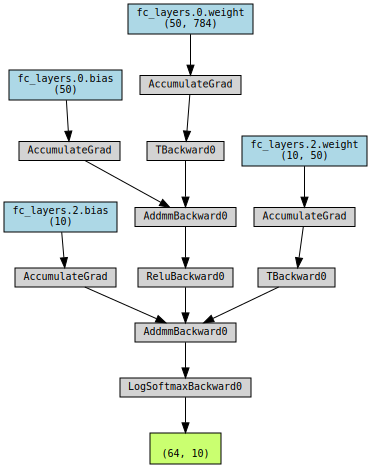

In [40]:
y_pred = mlp2(images)
torchviz.make_dot(y_pred, params=dict(mlp2.named_parameters()))#,show_attrs=True, show_saved=True)

## Loss and Optimizer

### For the loss function, we'll use PyTorch's built in negative log-likelihood loss since our model outputs probabilities.

- The `forward()` function performs the actual calculation/operation of the block and returns an output.
- The `backward()` function computes the gradient of the **input and parameters** as a function of the gradient of the **output**, according to the chain rule.

<img src="backprop.png" width="900" />

- MSE loss with L2 regularization:
    $$
    \begin{align}
    \ell(\vec{y},\vec{\hat y}) &= \frac{1}{2} \norm {\vec{\hat y} - \vec{y}}^2 \\
    L_{\mathcal{S}} &= \frac{1}{N}\sum_{i=1}^{N}\ell(\vec{y},\vec{\hat y}) + \frac{\lambda}{2}\left(\norm{\mat{W}_1}_F^2 + \norm{\mat{W}_2}_F^2 \right)
    \end{align}
    $$


In [45]:
model = mlp5

In [46]:
import torch.optim

# Loss: Negative Log Likelihood Loss
# Note: NLLLoss assumes *log*-probabilities (given by our LogSoftmax layer)
loss_fn = nn.NLLLoss()

# Optimizer over our model's parameters
optimizer = torch.optim.SGD(params=model.parameters(), lr=5e-2, weight_decay=0.01, momentum=0.9)    # learning rate --> the "step size"
                                                                                                    # weight_decay --> L2 regularizations
                                                                                                    # momentum --> averages the data

### Batch Gradient Descent
<img src="gdp.png" width="400" />

### Stochastic Gradient Descent
<img src="sgd-1.jpg" width="400" />

In [47]:
def plot_weights(model: MLP):
    '''
    Plots some weights matrices of the first layer
    '''
    fig, axes = plt.subplots(3,3)
    weights = list(model.fc_layers[0].parameters())[0]  # only weights of first layer
    
    for w, ax in zip(weights, axes.ravel()):
        ax.imshow(w.detach().numpy().reshape(28, 28));

        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

## Let's test the networks we created

## Training of MLP5

Epoch #1: Avg. loss=2.3004772663116455


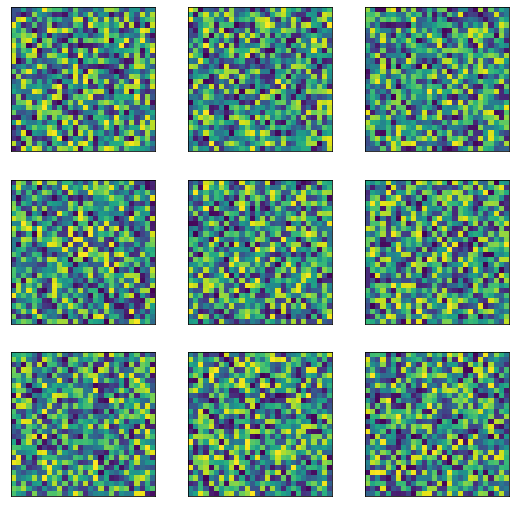

Epoch #2: Avg. loss=2.294303274154663


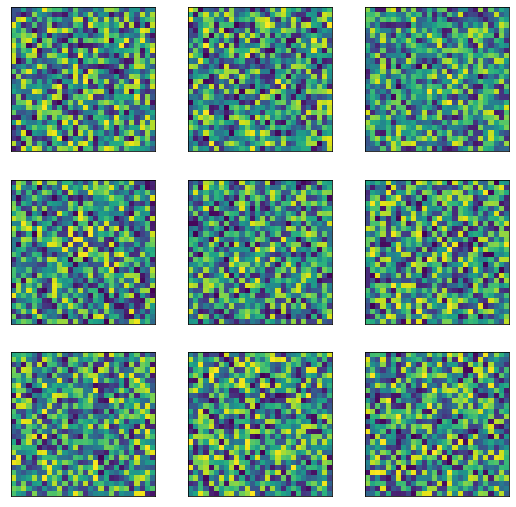

Epoch #3: Avg. loss=2.2834340572357177


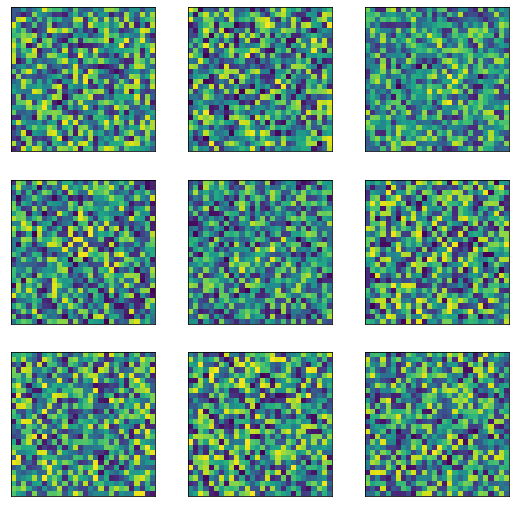

Epoch #4: Avg. loss=2.2545681953430177


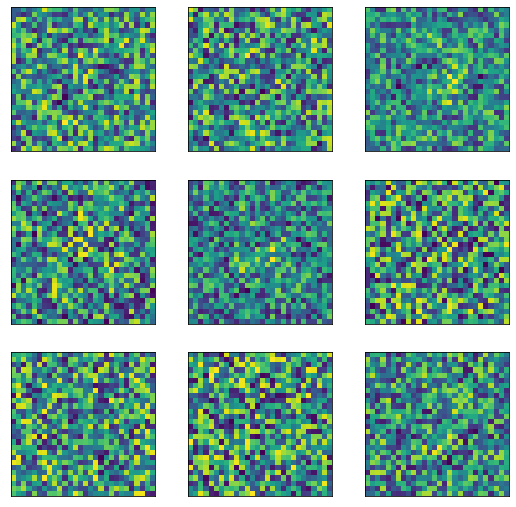

Epoch #5: Avg. loss=2.1162996530532836


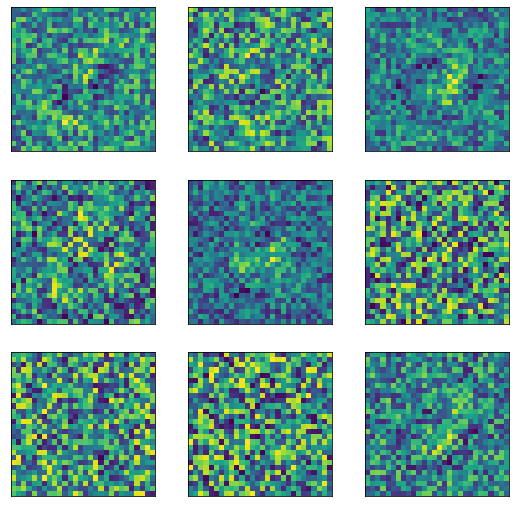

Epoch #6: Avg. loss=2.219141960144043


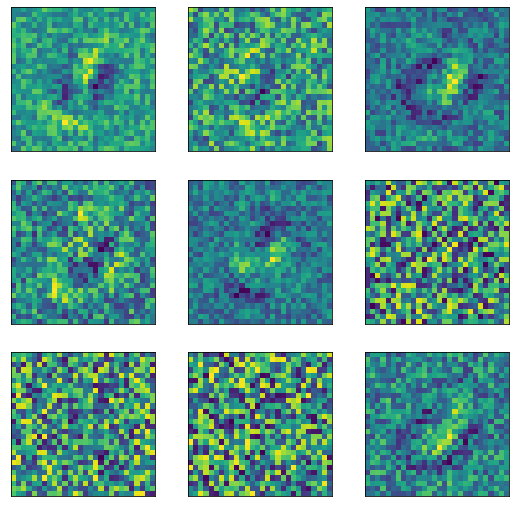

Epoch #7: Avg. loss=2.127126908302307


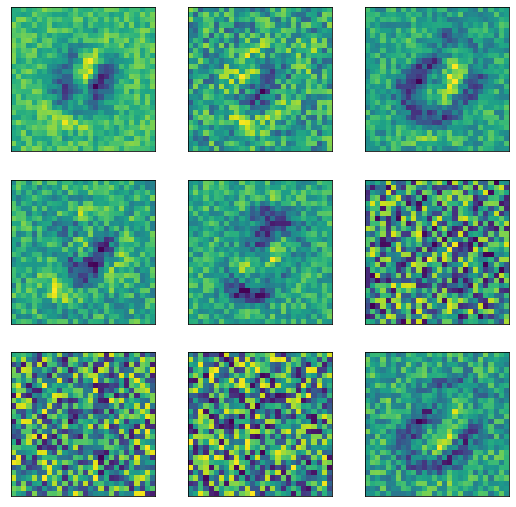

Epoch #8: Avg. loss=2.0163570284843444


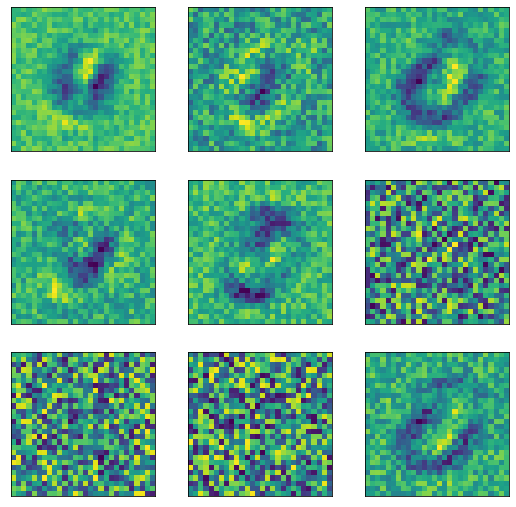

Epoch #9: Avg. loss=1.73850519657135


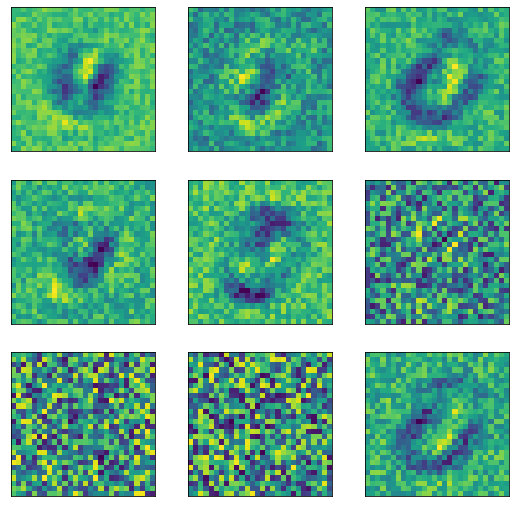

Epoch #10: Avg. loss=1.4591156482696532


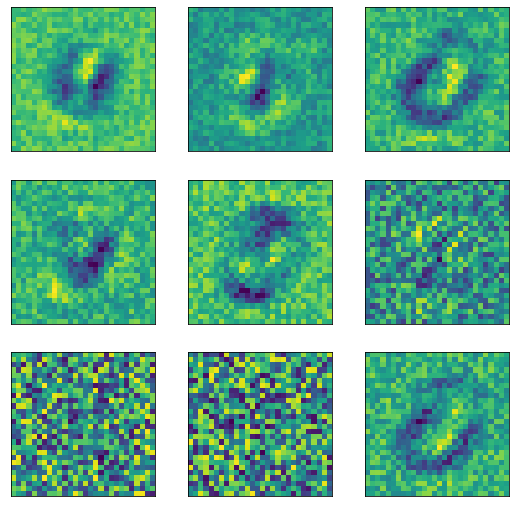

Epoch #11: Avg. loss=1.3903315782546997


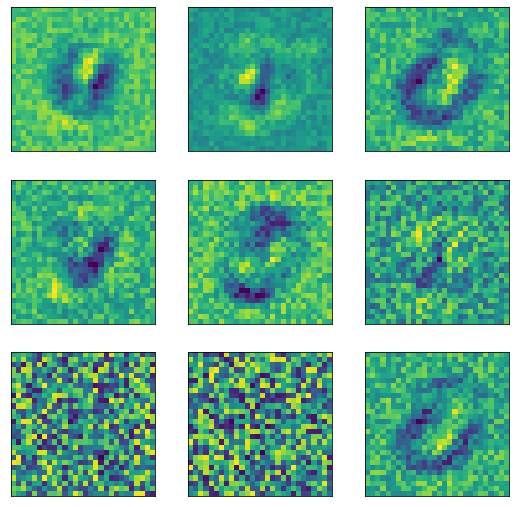

Epoch #12: Avg. loss=1.1287374377250672


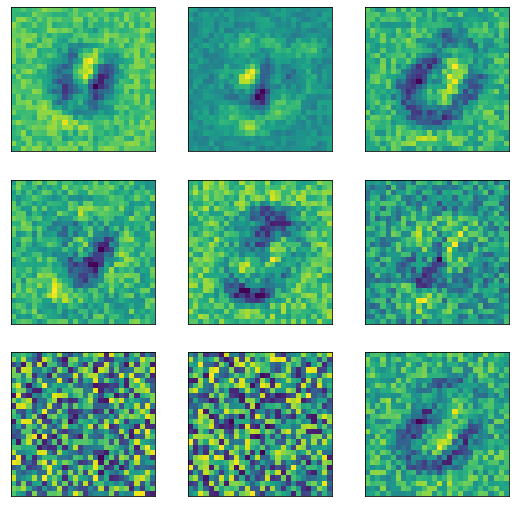

Epoch #13: Avg. loss=0.9678090929985046


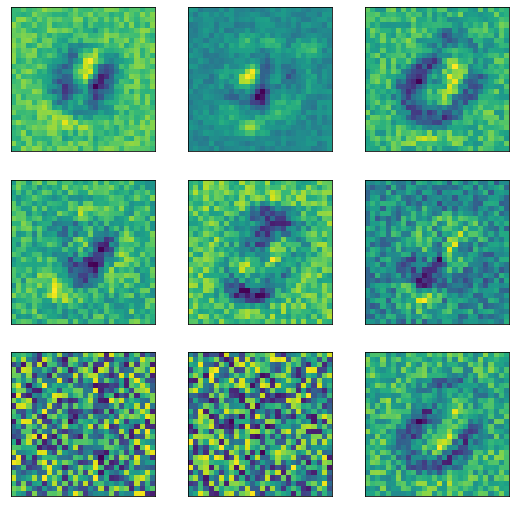

Epoch #14: Avg. loss=0.8747302114963531


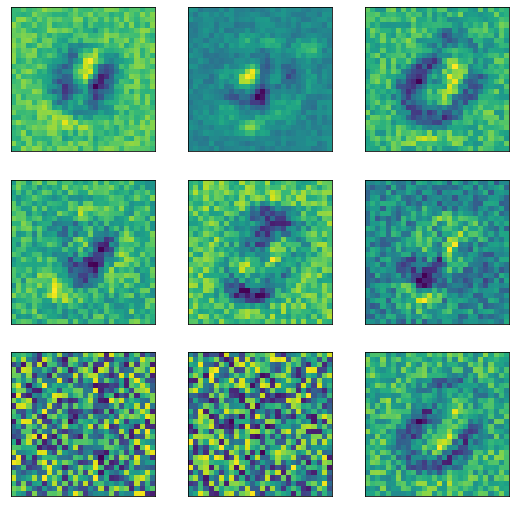

Epoch #15: Avg. loss=0.7689724504947663


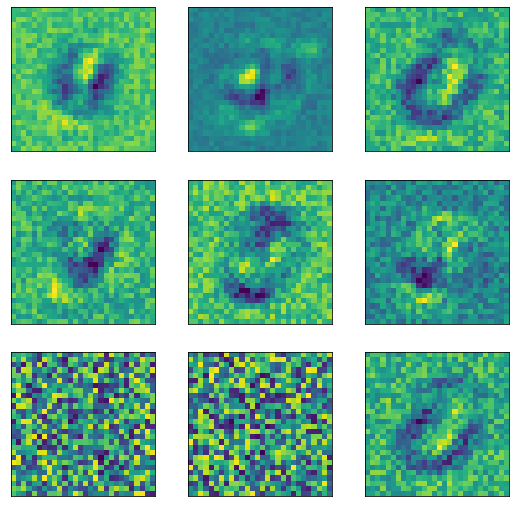

Epoch #16: Avg. loss=0.6599674761295319


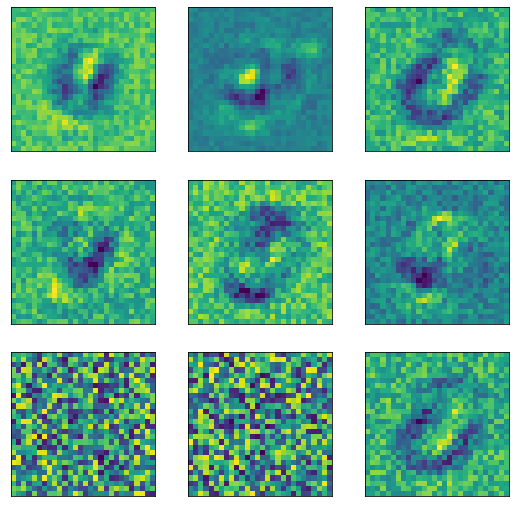

Epoch #17: Avg. loss=0.6089342951774597


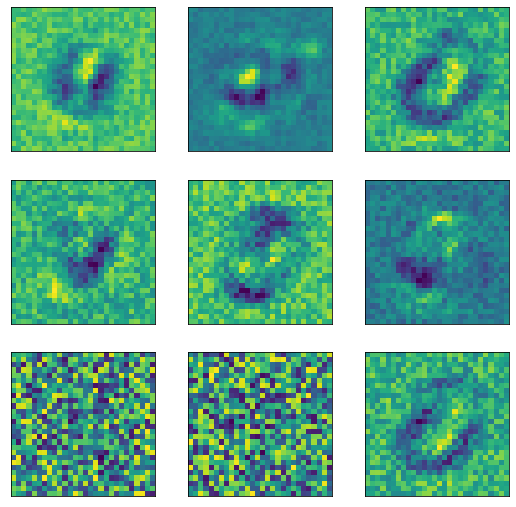

Epoch #18: Avg. loss=0.5474874913692475


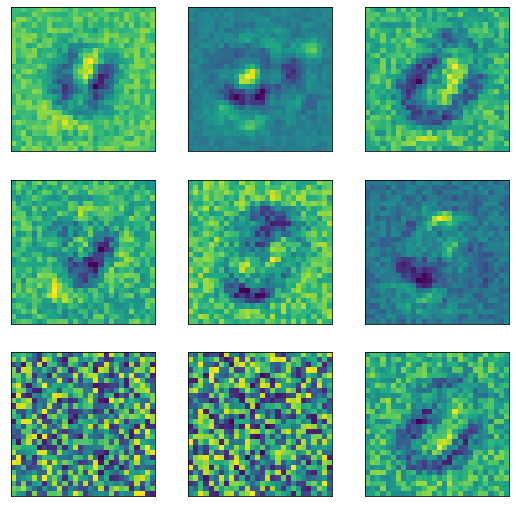

Epoch #19: Avg. loss=0.5431745231151581


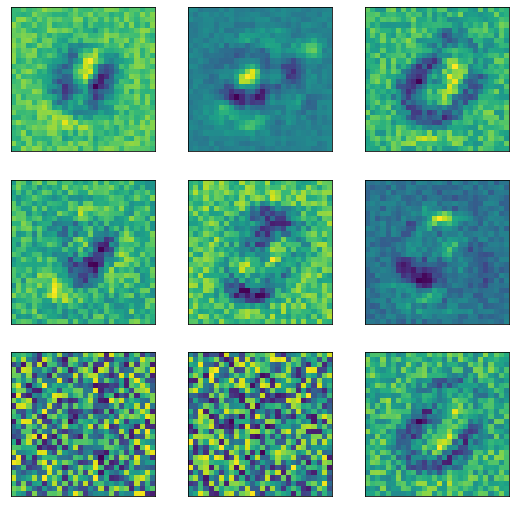

Epoch #20: Avg. loss=0.5200682699680328


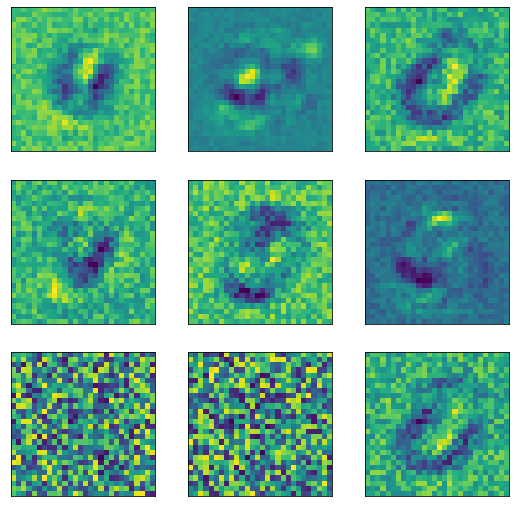

In [48]:
num_epochs = 20


for epoch_idx in range(num_epochs):
    total_loss = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        # Forward pass
        y_pred = model(X)       # similar to calling forward()
        
        # Compute loss
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()   # Zero gradients of all parameters
        loss.backward()         # Run backprop algorithms to calculate gradients
        
        # Optimization step
        optimizer.step()        # Use gradients to update model parameters
        
    
    print(f'Epoch #{epoch_idx + 1}: Avg. loss={total_loss / len(train_loader)}')
    plot_weights(model)

## Calculate precision score  of our network

In [49]:
def score():
    correct = 0
    for batch in test_loader:

        #  images, true labels
        for image, label in zip(batch[0], batch[1]):
            y_pred = model(image)

            if torch.topk(y_pred, 10).indices[0].numpy()[0] == label:
                correct += 1
    
    return correct

In [50]:
# count correct predictions
correct = score()

print(f'Prediction Precision: {correct} / {TEST_SIZE}. ({correct / TEST_SIZE})')

Prediction Precision: 819 / 1024. (0.7998046875)


## Let's try with the simple MLP2 architecure

In [51]:
model = mlp2

In [52]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=5e-2, weight_decay=0.01, momentum=0.9)

Epoch #1: Avg. loss=1.8706410765647887


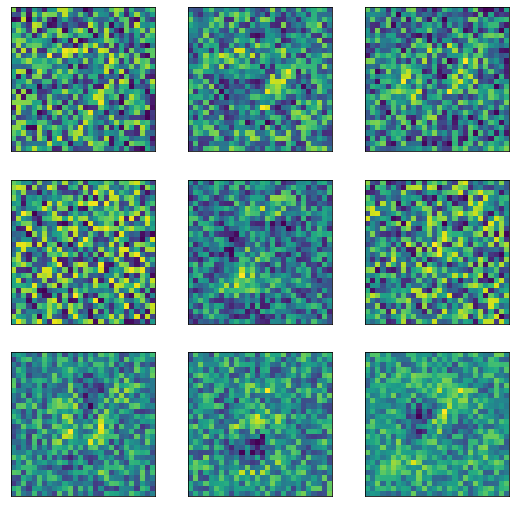

Epoch #2: Avg. loss=0.7692256808280945


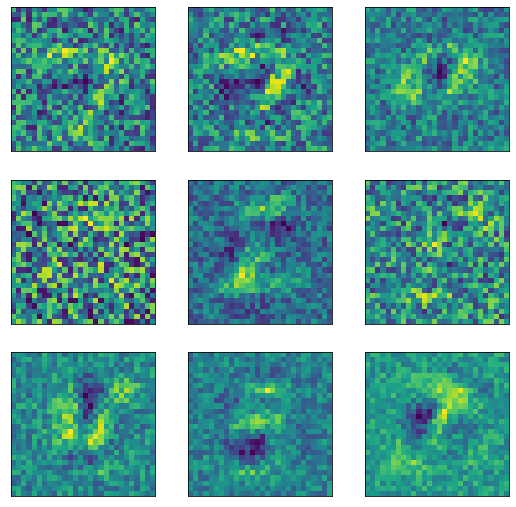

Epoch #3: Avg. loss=0.4884571939706802


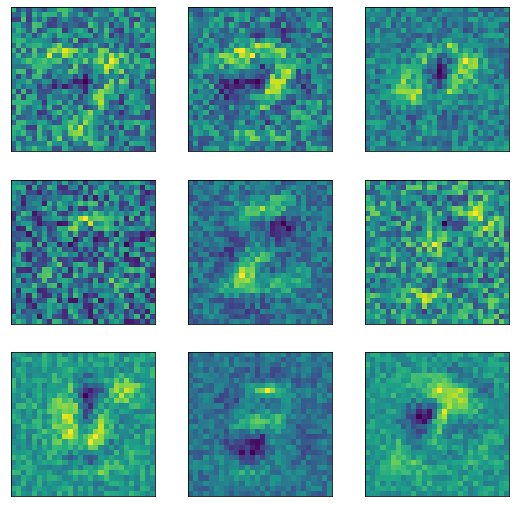

Epoch #4: Avg. loss=0.3956465244293213


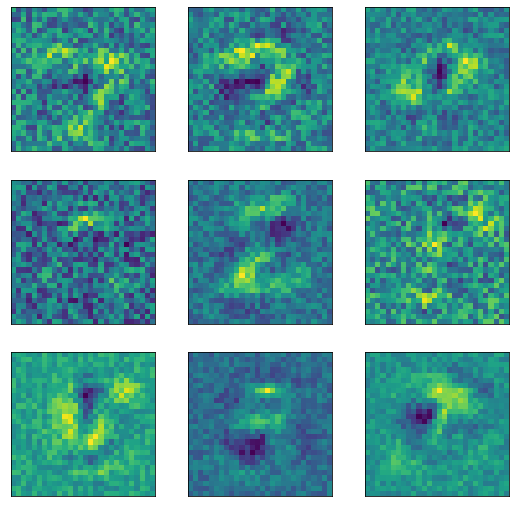

Epoch #5: Avg. loss=0.33338452577590943


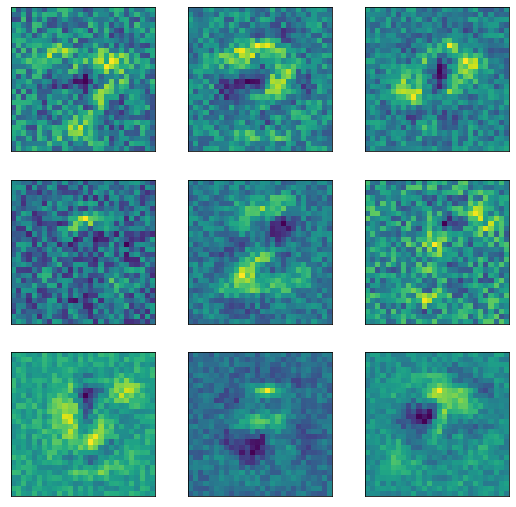

Epoch #6: Avg. loss=0.31668211817741393


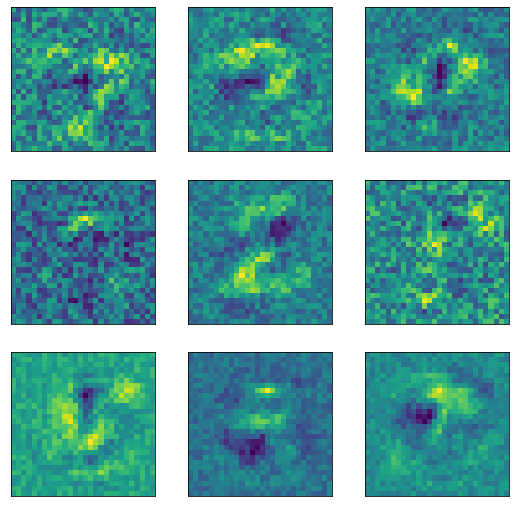

Epoch #7: Avg. loss=0.28760613352060316


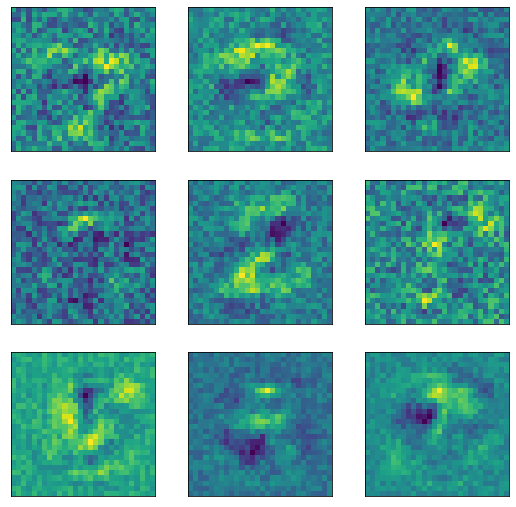

Epoch #8: Avg. loss=0.2829118639230728


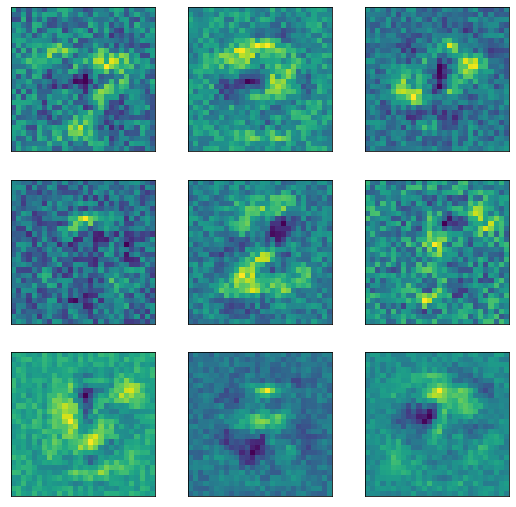

Epoch #9: Avg. loss=0.2650420591235161


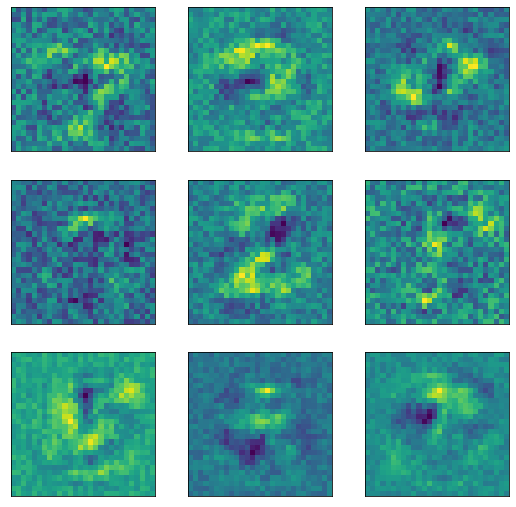

Epoch #10: Avg. loss=0.25964204370975497


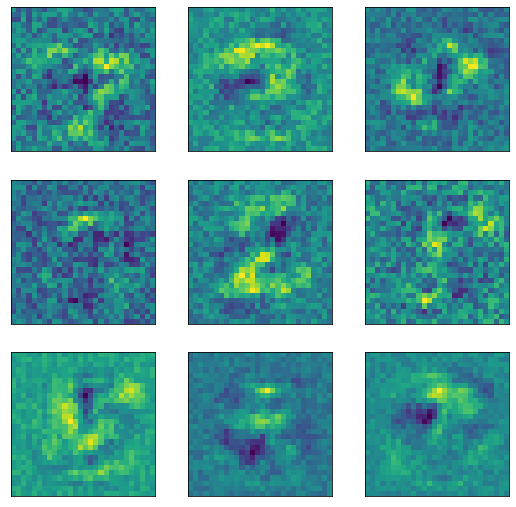

Epoch #11: Avg. loss=0.24358488619327545


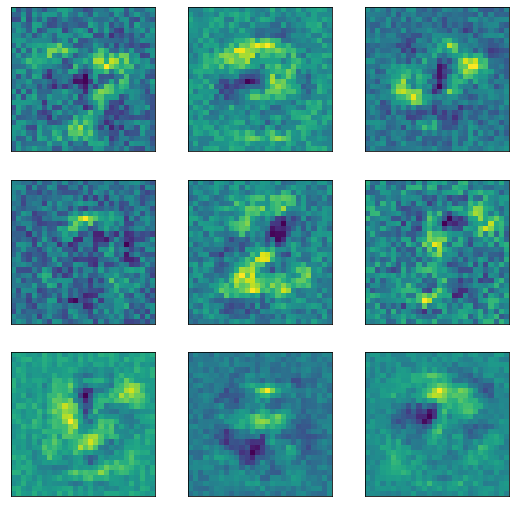

Epoch #12: Avg. loss=0.23834094554185867


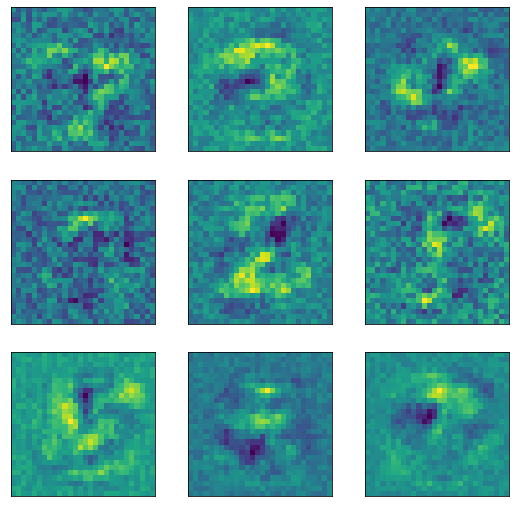

Epoch #13: Avg. loss=0.23347421437501908


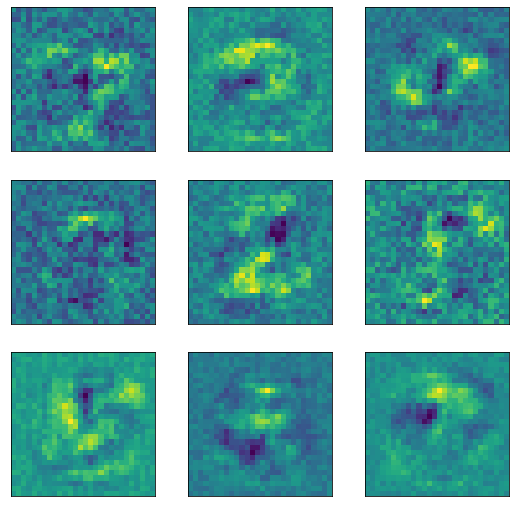

Epoch #14: Avg. loss=0.21882878243923187


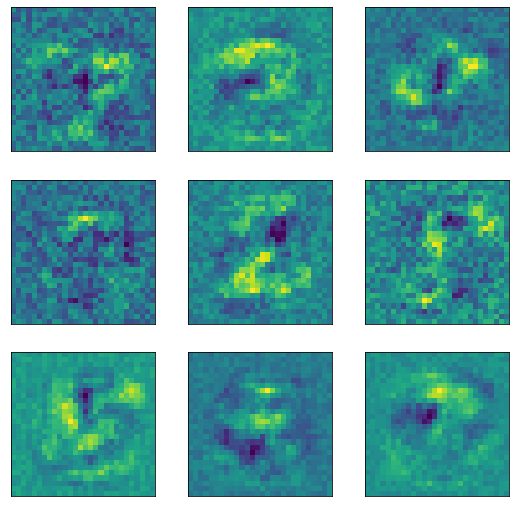

Epoch #15: Avg. loss=0.2157795399427414


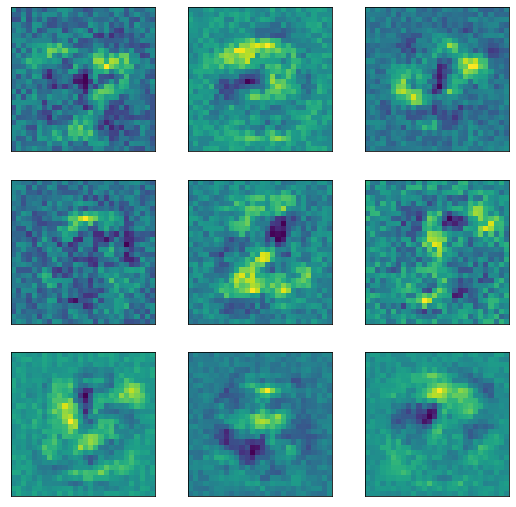

Epoch #16: Avg. loss=0.2109357923269272


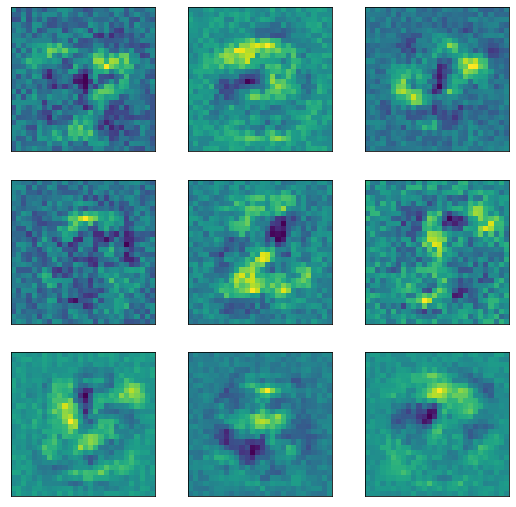

Epoch #17: Avg. loss=0.21614791005849837


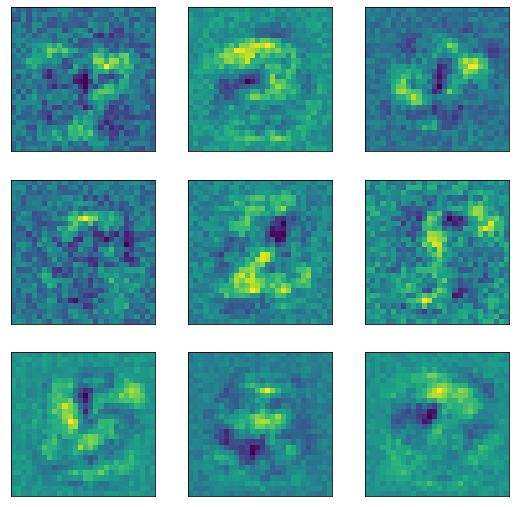

Epoch #18: Avg. loss=0.21039092987775804


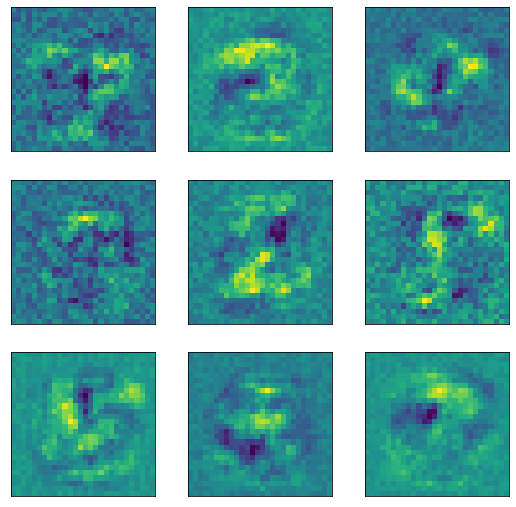

Epoch #19: Avg. loss=0.20620021224021912


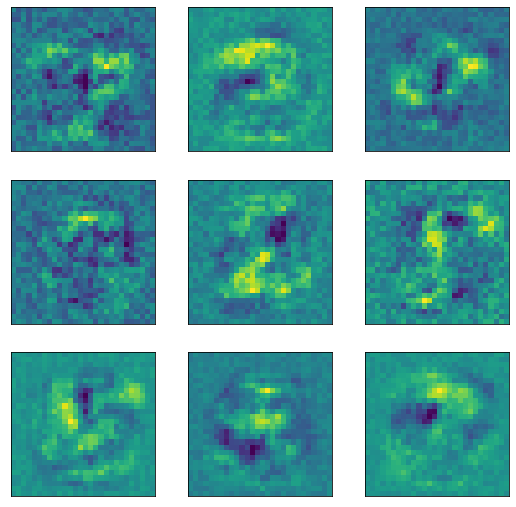

Epoch #20: Avg. loss=0.20060877352952958


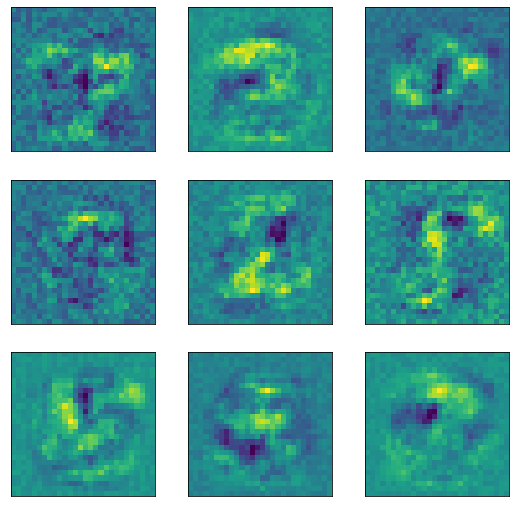

In [53]:
num_epochs = 20


for epoch_idx in range(num_epochs):
    total_loss = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        # Forward pass
        y_pred = model(X)      
        
        # Compute loss
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()   # Zero gradients of all parameters
        loss.backward()         # Run backprop algorithms to calculate gradients
        
        # Optimization step
        optimizer.step()        # Use gradients to update model parameters
        
    
    print(f'Epoch #{epoch_idx + 1}: Avg. loss={total_loss / len(train_loader)}')
    plot_weights(model)

In [54]:
# count correct predictions
correct = score()

print(f'Prediction Precision: {correct} / {TEST_SIZE}. ({correct / TEST_SIZE})')

Prediction Precision: 927 / 1024. (0.9052734375)


## Conclusion: MLP2 performs better than MLP5 that overfits

# Sci-Kit Learn Approach

In [1]:
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0

# Split data into train partition and test partition
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.7)

In [55]:
# create a similar network architecture as we did with pytorch
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 64, 128, 64),
    max_iter=10,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.2,
)

In [56]:
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.45821554
Iteration 2, loss = 0.45886510
Iteration 3, loss = 0.33400690
Iteration 4, loss = 0.28038989
Iteration 5, loss = 0.25035758
Iteration 6, loss = 0.23560511
Iteration 7, loss = 0.21840949
Iteration 8, loss = 0.20850437
Iteration 9, loss = 0.19261652
Iteration 10, loss = 0.19492898


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64), learning_rate_init=0.2,
              max_iter=10, random_state=1, solver='sgd', verbose=10)

In [57]:


print(f'Training set score: {mlp.score(X_train, y_train)}')
print(f'Test set score:     {mlp.score(X_test, y_test)}')



Training set score: 0.9501428571428572
Test set score:     0.9230204081632654


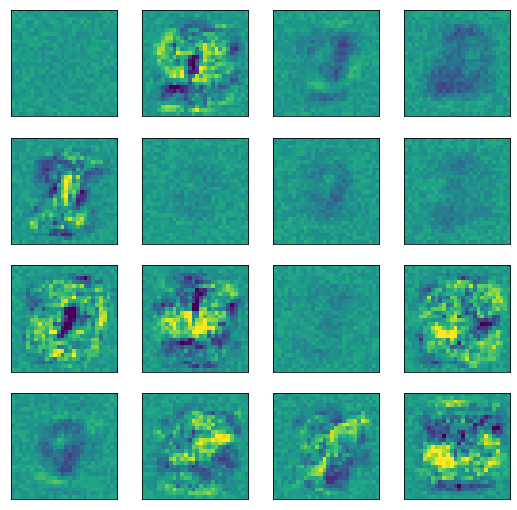

In [58]:
fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
# use global min / max to ensure all weights are shown on the same scale

for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), vmin=.5 * vmin,
    vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
    

plt.show()


In [59]:
plt.close()